In [1]:
import pandas as pd
import numpy as np

import src.iodata as iodata
import src.preprocess as preproc
import src.markovchain as mchain
import src.visualize as visualize
from matplotlib import pyplot as plt

# XBTUSD

In [2]:
ticker = 'XBTUSD'
df = iodata.get_df(ticker)
# Time resolution is 1ms, so duplicate might occur, keep last.
df = df[~df.index.duplicated(keep='last')]
df['time'] = df['time'].dt.tz_localize(None)
df.index = df.index.tz_localize(None)
df.head(5)

,bs,bid,ask,as,time,mid,imb,wmid
timestamp,,,,,,,,
2020-12-14 00:07:24.057,83434.0,19077.0,19077.5,890861.0,2020-12-14 00:07:24.057,19077.25,0.085635,19077.042818
2020-12-14 00:07:24.072,83434.0,19077.0,19077.5,902353.0,2020-12-14 00:07:24.072,19077.25,0.084637,19077.042318
2020-12-14 00:07:24.081,83434.0,19077.0,19077.5,906348.0,2020-12-14 00:07:24.081,19077.25,0.084295,19077.042148
2020-12-14 00:07:24.095,83434.0,19077.0,19077.5,911348.0,2020-12-14 00:07:24.095,19077.25,0.083872,19077.041936
2020-12-14 00:07:24.097,83434.0,19077.0,19077.5,917348.0,2020-12-14 00:07:24.097,19077.25,0.083369,19077.041684


In [3]:
n_imb = 10
n_spread = 3
dt = 1
ticker = 'XBTUSD'
df = iodata.get_df(ticker)
df, misc = preproc.discretize(df, n_imb, dt, n_spread)
df = preproc.mirror(df, misc)

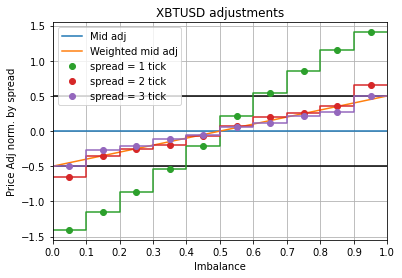

In [4]:
G1, B, Q, Q2, R1, R2, K = mchain.estimate(df)
Gstar, Bstar = mchain.calc_price_adj(G1, B, order='stationary')
visualize.plot_Gstar(ticker, Gstar, misc)

pmf(s = 1 tick) = 0.37
pmf(s = 2 tick) = 0.41
pmf(s = 3 tick) = 0.22


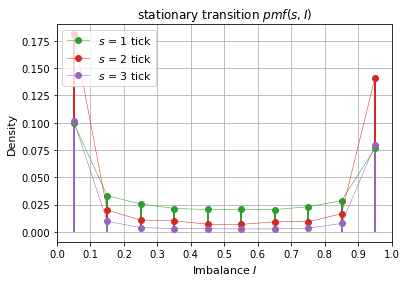

In [5]:
Bstar_pdf = Bstar.iloc[0]  # ~= np.linalg.matrix_power(B,10).iloc[0]
Bstar_pdf = pd.Series(np.linalg.matrix_power(B, 5)[0], index=B.columns)
visualize.plot_Bstar(Bstar_pdf, misc)

# Experimental

Text(0, 0.5, 'change [ticksize]')

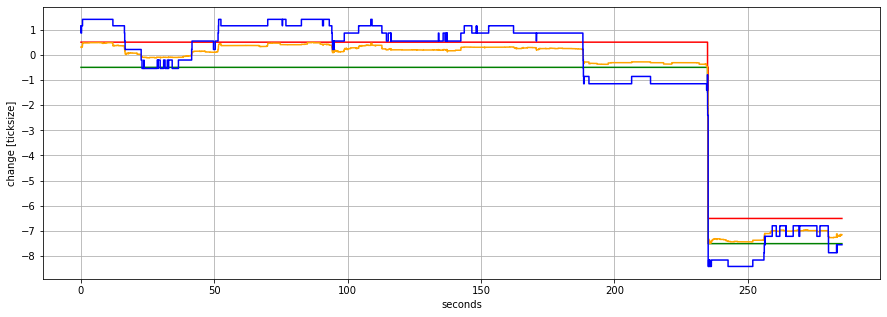

In [6]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
tmp = pd.DataFrame(Gstar, columns=['micropriceadj'])
df2 = pd.merge(df[~df['mirrored']], tmp, left_on=['spread', 'imb_bucket'], right_index=True, how='inner')
df2['microprice'] = df2['mid'] + df2['micropriceadj']

df2.sort_values(by=['time'], inplace=True)
view = df2.iloc[1000:3500]

plt.figure(figsize=(15, 5))
ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

incep = view['time'].iloc[0]
timedelta = (view['time']-incep) / pd.Timedelta('1 seconds')
yoffset = view['mid'].iloc[0]
rel_values = lambda ds:  (ds - yoffset) / misc['ticksize']
plt.step(timedelta, rel_values(view['bid']), color='g')
plt.step(timedelta, rel_values(view['ask']), color='r')
plt.step(timedelta, rel_values(view['wmid']), color='orange')
plt.step(timedelta, rel_values(view['microprice']), color='b')
plt.grid()
plt.xlabel('seconds')
plt.ylabel('change [ticksize]')

(0.0, 1.0)

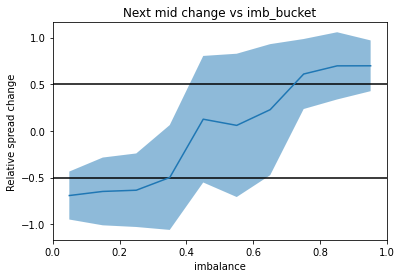

In [7]:

frm = df[~df['mirrored']].copy()
frm['spreadticks'] = (frm['spread'] / misc['ticksize']).round()
frm = frm[frm['spreadticks']==1.0]
frm['dMn'] = frm['dM'] / frm['spread']
view = frm[frm['dMn']!=0.0]
res = view.groupby('imb_bucket')['dMn'].agg(['mean', 'std'])

xx = misc['imb_bucket_mid'][res.index]
plt.figure()
plt.plot(xx, res['mean'])
plt.fill_between(xx, res['mean'] - res['std'], res['mean'] + res['std'], alpha=0.5)
plt.hlines(-0.5, 0, 1, color='k')
plt.hlines(0.5, 0, 1, color='k')
plt.title('Next mid change vs imb_bucket')
plt.xlabel('imbalance')
plt.ylabel('Relative spread change')
plt.xlim([0, 1])